In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import numpy.random as alea
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from random import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import progressbar
import momAPI.nn.indexed_dataset as indexed_dataset
import momAPI.nn.utilities as utilities
import momAPI.nn.MOM_training as MOM_training
import momAPI.nn.MOM_sampler as MOM_sampler
from math import log

momAPI package
In nn __init__
In procedure __init__
In Cross_validation __init__
In Linear_models __init__


In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
random_seed = 7
alea.seed(random_seed)

#### Data importation

We want to classify the images of tiny-imageNet

In [4]:
images = []
targets = []
min_n , min_p = 1000 , 1000
n_samples, i = 0, 0
types = os.listdir("data/tiny-imagenet-full/train")
for typ in progressbar.progressbar(types[:10]):
    
    file = os.listdir("data/tiny-imagenet-full/train/" + typ + "/images")
    
    for f in file: 
        
        img = Image.open("data/tiny-imagenet-full/train/" + typ + "/images/" + f)
        n,p = img.size
        #height = min(n,p)
        #box = ( 0 , 0 , height , height)
        #img = img.crop(box)  # On rend l'image carré en la rognant
        if len(np.array(img).shape) == 3 : 
            images.append(np.array(img)/255)
            targets.append(i)
        
    i += 1

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(images, targets, random_state = random_seed)

In [6]:
target_train = torch.LongTensor(Y_train)
target_test = torch.LongTensor(Y_test)

### Data transformation

First we create a transformer in order to transform np.array to torch.tensor with the channels in the first dimension.

In [7]:
transformer = transforms.Compose( [ transforms.ToTensor() ])

In [8]:
data_train = indexed_dataset.Dataset(X_train , target_train , transform = transformer)
data_test = indexed_dataset.Dataset(X_test , target_test , transform = transformer)

### The network

In [60]:
1- 30/775 

0.9612903225806452

In [42]:
class CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3 , 64 , 64)
    
    def __init__(self):
        super(CNN, self).__init__()
        
        #input channels = 3, output channels = 16
        self.block_1 = nn.Sequential(torch.nn.Conv2d(3 , 32 , 3 , stride = 1 , padding = 0),
                                     nn.BatchNorm2d(32),
                                     nn.ReLU(),
                                     torch.nn.MaxPool2d(3))
        
        #Input channels = 16, output channels = 32
        self.block_2 = nn.Sequential(torch.nn.Conv2d(32 , 64 , 3 , stride = 1 , padding = 0),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(),
                                     torch.nn.MaxPool2d(2))
        
        #Input channels = 32, output channels = 64
        self.block_3 = nn.Sequential(torch.nn.Conv2d(64 , 128 , 3 , stride = 1 , padding = 0),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     torch.nn.MaxPool2d(2))
        
        #128 input features, 1 output features for binary classification
        self.fc1 = torch.nn.Linear(1152, 10)
        
        self.conv_dropout = nn.Dropout2d(p = 0.0)
        self.dense_dropout = nn.Dropout(p = 0.5)
        
    def forward(self, x):
        #print("1:", (x == x).all())
        #Computes the Fivation of the first convolution
        #Size changes from (3, 64, 64) to (16, 32, 32)
        x = self.block_1(x)
        #print(x.size())
        #print("1:", (x == x).all())
        
        #Size changes from (16, 32, 32) to (32, 16, 16)
        x = self.block_2(x)
        #print(x.size())
        #print("2:", (x == x).all())
        
        #Size changes from (32, 16, 16) to (64, 6, 6)
        x = self.block_3(x)
        #print(x.size())
        #print("3:", (x == x).all())
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (128 , 1 , 1) to (1, 128)
        #Recall that the -1 infers this dimension from the other given dimension
        #print(x.size())
        x = x.view(-1,1152)
        
        #Computes the Fivation of the fully connected layer
        #Size changes from (1, 2304) to (1, 1)
        x = torch.nn.functional.softmax(self.dense_dropout(self.fc1(x)),dim = 1)
        
        return(x)

We use Adam optimizer and our loss is the classical cross entropy which on M classes can be calculated with the following formula : 
$$ CE(y,\widehat{y}) = -\sum_{c = 1}^{M}{y_c log(\widehat{y}_c)+(1-y_c)log(1-\widehat{y}_c)}$$
with $y,\widehat{y} \in \mathbb{R}^M$ and $y_i$ (resp $\widehat{y}_i$) denotes the i-th element of y (resp $\widehat{y}$).

In [43]:
CNN_ = CNN()
optimizer = torch.optim.Adam( CNN_.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,
                                          weight_decay=0, amsgrad=False)
loss_ = torch.nn.CrossEntropyLoss()

In [44]:
MOM_CNN = MOM_training.mom_net(CNN_ , optimizer , loss_ , random_seed = random_seed, n_epochs = 600 , batch_size = 32, n_hist = 400)
MOM_CNN.fit(data_train, data_test)
#torch.save(MOM_CNN.model.state_dict(), "models/multiclass_CNN_1")

Epoch n°0 ( 6.0 sec) : loss = 2.304337501525879 ,validation loss =  2.2993199825286865 , accuracy : 0.11925866236905722 , validation accuracy : 0.12399355877616747
Epoch n°1 ( 6.0 sec) : loss = 2.2989258766174316 ,validation loss =  2.288688898086548 , accuracy : 0.136986301369863 , validation accuracy : 0.13526570048309178
Epoch n°2 ( 6.0 sec) : loss = 2.2739436626434326 ,validation loss =  2.291412830352783 , accuracy : 0.13376309427880742 , validation accuracy : 0.10950080515297907
Epoch n°3 ( 6.0 sec) : loss = 2.332693338394165 ,validation loss =  2.2819135189056396 , accuracy : 0.1434327155519742 , validation accuracy : 0.13365539452495975
Epoch n°4 ( 6.0 sec) : loss = 2.2813913822174072 ,validation loss =  2.2788965702056885 , accuracy : 0.1380607037335482 , validation accuracy : 0.14412238325281804
Epoch n°5 ( 6.0 sec) : loss = 2.2571349143981934 ,validation loss =  2.2744898796081543 , accuracy : 0.1415525114155251 , validation accuracy : 0.1529790660225443
Epoch n°6 ( 6.0 sec)

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5dac0124e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_by

Epoch n°20 ( 6.0 sec) : loss = 2.241888999938965 ,validation loss =  2.2502942085266113 , accuracy : 0.2054794520547945 , validation accuracy : 0.18438003220611915
Epoch n°21 ( 6.0 sec) : loss = 2.2054831981658936 ,validation loss =  2.239905595779419 , accuracy : 0.19312382487241472 , validation accuracy : 0.19484702093397746
Epoch n°22 ( 6.0 sec) : loss = 2.2634549140930176 ,validation loss =  2.243356227874756 , accuracy : 0.2054794520547945 , validation accuracy : 0.20128824476650564
Epoch n°23 ( 6.0 sec) : loss = 2.2140915393829346 ,validation loss =  2.2369210720062256 , accuracy : 0.1998388396454472 , validation accuracy : 0.1972624798711755
Epoch n°24 ( 6.0 sec) : loss = 2.1434109210968018 ,validation loss =  2.236273765563965 , accuracy : 0.2081654579640075 , validation accuracy : 0.21336553945249598
Epoch n°25 ( 6.0 sec) : loss = 2.1722636222839355 ,validation loss =  2.24125075340271 , accuracy : 0.2108514638732205 , validation accuracy : 0.2028985507246377
Epoch n°26 ( 6.0 

In [20]:
history = MOM_CNN.history

Text(0.5, 1.0, 'Training curve')

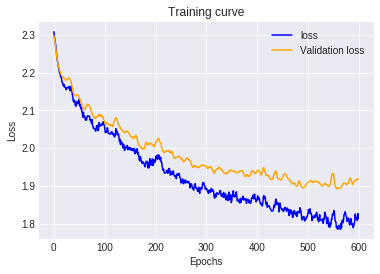

In [21]:
%matplotlib inline
plt.plot(history['loss'] , color = "blue" , label = "loss")
plt.plot(history['val_loss'] , color = 'orange' , label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training curve")

Text(0.5, 1.0, 'Training curve')

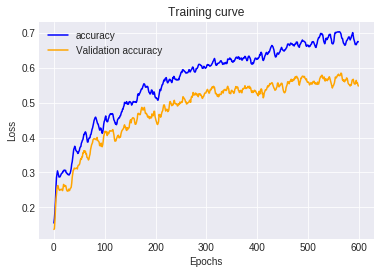

In [22]:
%matplotlib inline
plt.plot(history['acc'] , color = "blue" , label = "accuracy")
plt.plot(history['val_acc'] , color = 'orange' , label = "Validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training curve")

#### Model evaluation

In [28]:
%matplotlib inline

test_data_x = torch.stack([data_test[i][0] for i in range(len(data_test))]).float()
test_data_y = torch.stack([data_test[i][1] for i in range(len(data_test))]).long()
X = torch.Tensor(test_data_x)
Y = torch.LongTensor(test_data_y)
    
Y_pred = CNN_(X)
Y_real = np.array(Y)
#cm = confusion_matrix(Y_real , Y_pred)

#plot_confusion_matrix(cm , ['crocodile','pinguin'])

In [29]:
l = []
for i in Y_pred.detach().numpy():
    l.append(np.argmax(i))
np.array(l)

array([1, 0, 6, ..., 1, 8, 6])

Normalized confusion matrix
[[0.70940171 0.         0.17094017 0.02564103 0.00854701 0.01709402
  0.03418803 0.02564103 0.00854701 0.        ]
 [0.008      0.76       0.016      0.136      0.008      0.008
  0.016      0.032      0.         0.016     ]
 [0.05737705 0.00819672 0.6557377  0.18852459 0.01639344 0.00819672
  0.04918033 0.00819672 0.00819672 0.        ]
 [0.02608696 0.03478261 0.10434783 0.73043478 0.         0.00869565
  0.00869565 0.06086957 0.         0.02608696]
 [0.0859375  0.0234375  0.046875   0.1953125  0.4140625  0.015625
  0.109375   0.03125    0.0234375  0.0546875 ]
 [0.02307692 0.00769231 0.03846154 0.1        0.03076923 0.29230769
  0.31538462 0.03076923 0.01538462 0.14615385]
 [0.0078125  0.0390625  0.         0.1015625  0.015625   0.0234375
  0.6171875  0.0625     0.0546875  0.078125  ]
 [0.04385965 0.06140351 0.04385965 0.11403509 0.00877193 0.05263158
  0.13157895 0.38596491 0.07894737 0.07894737]
 [0.00699301 0.         0.02797203 0.06993007 0.02097902 0.0

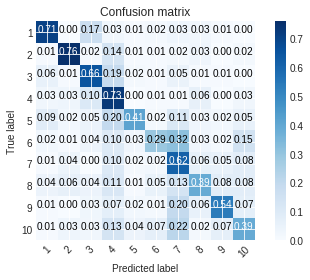

In [30]:
%matplotlib inline
cm = confusion_matrix(Y_real , l)

utilities.plot_confusion_matrix(cm, [1,2,3,4,5,6,7,8,9,10], normalize = True)

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_real , l)

0.5475040257648953

#### Outliers detection

array([5., 4., 5., ..., 2., 5., 7.])

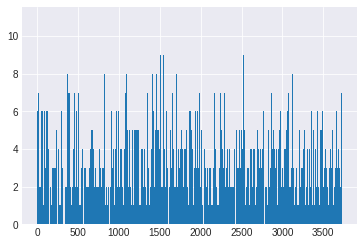

In [32]:
non_outliers = np.unique(MOM_CNN.history['hist'])
plt.hist(MOM_CNN.history['hist'] , bins = np.arange(len(data_train)))[0]

In [33]:
outliers = []

for i in range(len(data_train)):
    if i not in non_outliers:
        outliers.append(i)

In [34]:
dico = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8 : 0, 9 : 0}
for i in outliers : 
    dico[int(data_train[i][1])] += 1

In [35]:
dico

{0: 10, 1: 12, 2: 12, 3: 12, 4: 9, 5: 14, 6: 8, 7: 11, 8: 12, 9: 12}